# Librerias

In [206]:
# Librerias
import os

import pandas as pd
import numpy as np
import json

import regex as re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

#ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from pickle import dump


#Constantes

LEMMATIZER = WordNetLemmatizer()

STOPWORDS = stopwords.words("english")

URL = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"

# Obtencion de Datos

In [191]:
def GetData(path):
    data = pd.read_csv(path)
    
    parsedata= data.to_dict(orient="records")
    with open("../data/raw/data_raw.json", "w") as f:
        json.dump(parsedata, f)
        
    return data

data = GetData(URL)

# Procesamiento de los Datos

In [192]:
def ProcessingData(dataset):
    print(f"Data Dimensions: {dataset.shape}\n==========\n\n")
    
    #Codificamos el Spam
    print("Encoding Data...\n")
    onehotdata = pd.get_dummies(dataset, columns=["is_spam"], drop_first=True)
    
    #Aprovechamos este paso para eliminar duplicados
    print("Erasing Duplicates...\n")
    onehotdata = onehotdata.drop_duplicates()
    onehotdata = onehotdata.reset_index(drop=True)
    
    print(f"New Data Dimensions: {onehotdata.shape}\n")
    print(f"Spam Links: {(onehotdata['is_spam_True'].sum())} | Non Spam links: {(onehotdata['is_spam_True'] == False).sum()}\n==========\n\n")
    
    #Vamos a limpiar los caracteres especiales.
    print("Erasing Url Text...")
    print(onehotdata.head())
    #Eliminamos todo lo que no sea minusculas o espacios.
    onehotdata["url"] = onehotdata["url"].apply(lambda x: re.sub(r"[^a-z ]", " ", x))
    print(onehotdata.head())
    #Eliminamos espacios en blanco
    onehotdata["url"] = onehotdata["url"].apply(lambda x: re.sub(r"\s+[a-zA-Z]\s+|\^[a-zA-Z]\s+", " ", x))
    print(onehotdata.head())
    #Convertimos posibles tabulaciones en espacios en blanco
    onehotdata["url"] = onehotdata["url"].apply(lambda x: re.sub(r'\s+', " ", x.lower()))
    print(onehotdata.head())
    #Eliminamos residuos de etiquetas HTML
    onehotdata["url"] = onehotdata["url"].apply(lambda x: re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", x))
    print(onehotdata.head())
    #Desglosamos la URL en palabras individuales.
    onehotdata["url"] = onehotdata["url"].apply(lambda x: x.split())
    print(onehotdata.head())
    
    onehotdata["url"] = onehotdata["url"].apply(lambda x: [LEMMATIZER.lemmatize(word) for word in x if word not in STOPWORDS and len(word) > 3])

    return onehotdata 
    
processed_data = ProcessingData(data)

processed_data

Data Dimensions: (2999, 2)


Encoding Data...

Erasing Duplicates...

New Data Dimensions: (2369, 2)

Spam Links: 244 | Non Spam links: 2125


Erasing Url Text...
                                                 url  is_spam_True
0  https://briefingday.us8.list-manage.com/unsubs...          True
1                             https://www.hvper.com/          True
2                 https://briefingday.com/m/v4n3i4f3          True
3   https://briefingday.com/n/20200618/m#commentform         False
4                        https://briefingday.com/fan          True
                                                 url  is_spam_True
0  https   briefingday us  list manage com unsubs...          True
1                             https   www hvper com           True
2                 https   briefingday com m v n i f           True
3   https   briefingday com n          m commentform         False
4                        https   briefingday com fan          True
                                 

,url,is_spam_True
0,"[http, briefingday, list, manage, unsubscribe]",True
1,"[http, hvper]",True
2,"[http, briefingday]",True
3,"[http, briefingday, commentform]",False
4,"[http, briefingday]",True
...,...,...
2364,"[http, theverge, disney, deepfake, face, swapp...",False
2365,"[http, smartcitiesworld, news, news, deepfake,...",False
2366,"[http, techcrunch, optimistic, view, deepfakes]",False
2367,"[http, technologyreview, startup, claim, deepf...",False


- Creamos una nube de palabras con las palabras más repetidas en las URL´s para verlas más claramente.

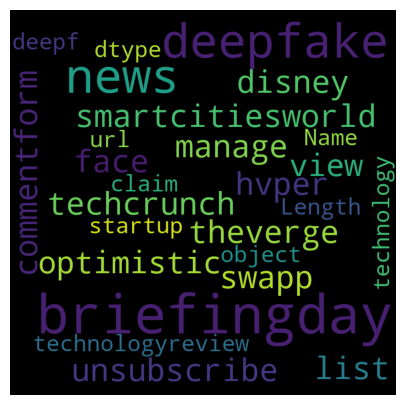

In [193]:
def WordCloudGraph(dataset):
    wc = (WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(dataset["url"])))
    
    fig = plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    
WordCloudGraph(processed_data)

- Para acabar, antes de pasar al Machine Learning vamos a vectorizar el texto y splitear la muestra en test y train.

In [194]:
def SplitData(dataset):
    #Tokenizamos los valores de las urls.
    tokens = dataset["url"]
    tokenized = [" ".join(token) for token in tokens]
    
    #Los vectorizamos
    vect_token = TfidfVectorizer(max_features=500, max_df= 0.8, min_df=5)
    x_vect = vect_token.fit_transform(tokenized).toarray()
    y = dataset["is_spam_True"]
    
    #Y lo spliteamos
    x_train, x_test, y_train, y_test = train_test_split(x_vect, y, test_size=0.2, random_state=42)
    
    return x_train, x_test, y_train, y_test

x_train_data, x_test_data, y_train_data, y_test_data = SplitData(processed_data)

# Creacion del SVM (Support Vector Machine)

In [202]:
#Creamos el modelo.
def BaseModel(x_train, y_train, x_test, y_test):
    model = SVC(kernel="linear", random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    score = accuracy_score(y_test, y_pred)
    print(f"Acurracy Score:{score}")
    
    return model

model = BaseModel(x_train_data, y_train_data, x_test_data, y_test_data)

Acurracy Score:0.9556962025316456


- Optimiacion de Hiperparametros

In [203]:
#Optimizamos el modelo.
def OptimizeParams(model, x, y):
    hp = {
        "C" : np.random.randint(0,100,10),
        "kernel" : ["lineal","poly","rbf","sigmoid"],
        "degree" : np.random.randint(0,6,10),
        "gamma" : ["scale", "auto"]
    }

    grid = GridSearchCV(model, hp, scoring="accuracy", cv=7)

    grid.fit(x, y)
    
    print(f"Best Parameters:{grid.best_params_}")
    
    return grid.best_params_
    
best_params = OptimizeParams(model, x_train_data, y_train_data)

KeyboardInterrupt: 

In [197]:
best_params

{'C': 4, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}

In [201]:
optimus_model = SVC(C=4, degree=4, gamma="scale", kernel="rbf", random_state=42)
optimus_model.fit(x_train_data, y_train_data)
y_pred = optimus_model.predict(x_test_data)

accuracy_score(y_test_data, y_pred)

0.9578059071729957

In [207]:
dump(optimus_model, open("../models/svm-c4-deg4-gamma_scake-kernelrbf-rs42.sav", "wb"))